<a href="https://www.kaggle.com/code/rebeccapringle/a-b-testing-maths-code-and-function?scriptVersionId=118378202" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A/B testing math and code with python

Here I present some A/B test examples and a function to automate the process

Procedure for an A/B test:
1. Import packages
2. Prepare data
3. Present conversion rates
4. Calculate stats and draw conclusion

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## Prepare data and remove reoccuring customers due to bias

In [2]:
# sample of what the collated data looks like
df = pd.read_csv('/kaggle/input/ab-data/ab_data.csv')
df.head()

# drop users that appear more than once
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
users_to_drop = session_counts[session_counts > 1].index
df1 = df[~df['user_id'].isin(users_to_drop)]

## Present conversion rates

In [3]:
# present conversion rates
conversion_rates = df1.groupby('group')['converted']
std_p = lambda x: np.std(x, ddof = 0)
se_p = lambda x: stats.sem(x, ddof = 0) 
conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.323,0.001


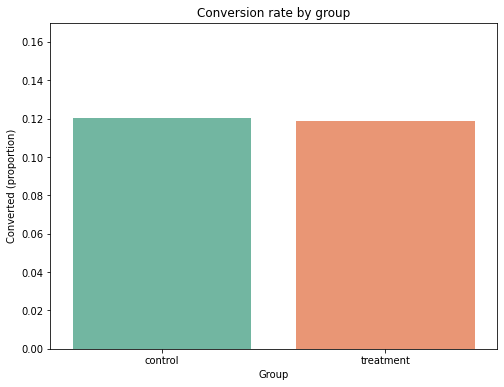

In [4]:
a = sns.color_palette("Set2")
# visualise conversion rates
plt.figure(figsize = (8,6))
sns.barplot(x = df1['group'], 
            y = df1['converted'], 
            ci=False,
           palette = a)
plt.ylim(0, 0.17)
plt.title('Conversion rate by group')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)');

## Calculate the key stats and conclusions

In [5]:
# calculate key statistics
control_results = df1[df1['group'] == 'control']['converted']
treatment_results = df1[df1['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.19
p-value: 0.232
ci 95% for control group: [0.118, 0.122]
ci 95% for treatment group: [0.117, 0.120]


The z-statistic indicates how many standard deviations the treatment mean is from the control mean.

The p-value is larger than 0.05 so we cannot reject the null hypothesis. There is no evidence that the outcome has changed.

The confidence interval of the treatment group lies entirely within the treatment group suggesting that no change has been observed.

Looking at a combination of metrics helps to make an accurate diagnosis.

# Another Example

In [6]:
df = pd.read_csv('/kaggle/input/audacity-ab-testing/homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [7]:
d = {'click': 1, 'view': 0}
df2 = df.replace(d)

In [8]:
conversion_rates = df2.groupby('group')['action']
conversion_rates = conversion_rates.agg([np.mean])
conversion_rates.columns = ['conversion_rate']
conversion_rates.style.format('{:.3f}')

,conversion_rate
group,
control,0.219
experiment,0.236


In [9]:
# calculate key statistics
control_results = df2[df2['group'] == 'control']['action']
treatment_results = df2[df2['group'] == 'experiment']['action']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs = nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.93
p-value: 0.053
ci 95% for control group: [0.206, 0.231]
ci 95% for treatment group: [0.223, 0.250]


The z-statistic shows that the experiment mean is 1.93 std dev below the control mean.

The p-value is larger than 0.05 so we cannot reject the null hypothesis. There is no evidence that the outcome has changed.

The confidence interval of the treatment group overlaps with the control group suggesting there is not enough evidence that a change has been observed.

Looking at a combination of metrics helps to make an accurate diagnosis.

## Function to quickly run AB test 

Variables needed to be known for this function to be applied:
1. clean dataframe
2. pos_action
3. neg_action

The data needs:
1. the outcome column with the title action
2. the two groups named control and experiment

In [10]:
def AB_test(df, pos_action, neg_action, alpha ):
    d = {pos_action: 1, neg_action: 0}
    df = df.replace(d)
    
    conversion_rates = df.groupby('group')['action']
    conversion_rates = conversion_rates.agg([np.mean])
    conversion_rates.columns = ['conversion_rate']
    conversion_rates.style.format('{:.3f}')
    display(conversion_rates)
    
    # calculate key statistics
    control_results = df[df['group'] == 'control']['action']
    treatment_results = df[df['group'] == 'experiment']['action']
    n_con = control_results.count()
    n_treat = treatment_results.count()
    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_con, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs = nobs)
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=alpha)

    print(f'z statistic: {z_stat:.2f}')
    print(f'p-value: {pval:.3f}')
    print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
    print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')
    if pval > 0.05:
        print('Accept null hypothesis')
    else:
        print('Reject null hypothesis')

AB_test(df2, 'click', 'view', 0.05)

df1 = df1.rename(columns = {'converted': 'action'})
AB_test(df1, '1','0',0.05)

,conversion_rate
group,
control,0.218574
experiment,0.236493


z statistic: -1.93
p-value: 0.053
ci 95% for control group: [0.206, 0.231]
ci 95% for treatment group: [0.223, 0.250]
Accept null hypothesis


,conversion_rate
group,
control,0.120173
treatment,0.118726


z statistic: nan
p-value: nan
ci 95% for control group: [0.118, 0.122]
ci 95% for treatment group: [nan, nan]
Reject null hypothesis


/opt/conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:839: RuntimeWarning: invalid value encountered in true_divide
  prop = count * 1. / nobs
/opt/conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:855: RuntimeWarning: divide by zero encountered in true_divide
  nobs_fact = np.sum(1. / nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/stats/proportion.py:89: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
